In [1]:
import numpy
import scipy.special
import scipy.ndimage

In [15]:
class neuralNetwork:    
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes

        self.wih = numpy.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))
        self.who = numpy.random.normal(0.0, pow(self.hnodes, -0.5), (self.onodes, self.hnodes))

        self.lr = learningrate
        self.activation_function = lambda x: scipy.special.expit(x)
        
    @staticmethod    
    def inverse_activation_function(x):
        return scipy.special.logit(x)
    
    
    def train(self, inputs_list, targets_list):
        inputs = numpy.array(inputs_list, ndmin=2).T
        targets = numpy.array(targets_list, ndmin=2).T
        
        hidden_inputs = numpy.dot(self.wih, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        final_inputs = numpy.dot(self.who, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)
        
        output_errors = targets - final_outputs
        hidden_errors = numpy.dot(self.who.T, output_errors)
        
        self.who += self.lr * numpy.dot((output_errors * final_outputs * (1.0 - final_outputs)), numpy.transpose(hidden_outputs))
        self.wih += self.lr * numpy.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), numpy.transpose(inputs))

    
    def query(self, inputs_list):
        inputs = numpy.array(inputs_list, ndmin=2).T
        
        hidden_inputs = numpy.dot(self.wih, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        final_inputs = numpy.dot(self.who, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)

        return final_outputs
    
    # backquery the neural network
    # we'll use the same termnimology to each item, 
    # eg target are the values at the right of the network, albeit used as input
    # eg hidden_output is the signal to the right of the middle nodes
    def backquery(self, targets_list):
        # transpose the targets list to a vertical array
        final_outputs = numpy.array(targets_list, ndmin=2).T
        
        # calculate the signal into the final output layer
        final_inputs = self.inverse_activation_function(final_outputs)

        # calculate the signal out of the hidden layer
        hidden_outputs = numpy.dot(self.who.T, final_inputs)
        # scale them back to 0.01 to .99
        hidden_outputs -= numpy.min(hidden_outputs)
        hidden_outputs /= numpy.max(hidden_outputs)
        hidden_outputs *= 0.98
        hidden_outputs += 0.01
        
        # calculate the signal into the hidden layer
        hidden_inputs = self.inverse_activation_function(hidden_outputs)
        
        # calculate the signal out of the input layer
        inputs = numpy.dot(self.wih.T, hidden_inputs)
        # scale them back to 0.01 to .99
        inputs -= numpy.min(inputs)
        inputs /= numpy.max(inputs)
        inputs *= 0.98
        inputs += 0.01
        
        return inputs

In [16]:
input_nodes = 784
hidden_nodes = 200
output_nodes = 10

learning_rate = 0.01

n = neuralNetwork(input_nodes,hidden_nodes,output_nodes, learning_rate)

In [9]:
training_data_file = open("mnist_dataset/mnist_train.csv", 'r')
training_data_list = training_data_file.readlines()[1:]
training_data_file.close()

In [10]:
epochs = 10

for e in range(epochs):
    for record in training_data_list:
        all_values = record.split(',')

        inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
        targets = numpy.zeros(output_nodes) + 0.01

        targets[int(all_values[0])] = 0.99
        n.train(inputs, targets)
        
        inputs_plusx_img = scipy.ndimage.interpolation.rotate(inputs.reshape(28,28), 10, cval=0.01, order=1, reshape=False)
        n.train(inputs_plusx_img.reshape(784), targets)
        
        inputs_minusx_img = scipy.ndimage.interpolation.rotate(inputs.reshape(28,28), -10, cval=0.01, order=1, reshape=False)
        n.train(inputs_minusx_img.reshape(784), targets)    

In [26]:
test_data_file = open("mnist_dataset/mnist_test.csv", 'r')
test_data_list = test_data_file.readlines()
test_data_file.close()

In [70]:
scorecard = []

for record in test_data_list[1:]:
    all_values = record.split(',')
    
    correct_label = int(all_values[0])
    inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
    outputs = n.query(inputs)
    label = numpy.argmax(outputs)
    if (label == correct_label):
        scorecard.append(1)
    else:
        scorecard.append(0)

In [73]:
scorecard_array = numpy.asarray(scorecard)
print ("Performance = ", scorecard_array.sum() / scorecard_array.size)

Performance =  0.976997699769977


In [24]:
from PIL import Image
def resize_image(input_image_path,
                 output_image_path,
                 size):
    original_image = Image.open(input_image_path)
    width, height = original_image.size

    resized_image = original_image.resize(size)
    resized_image.save(output_image_path)
    return resized_image

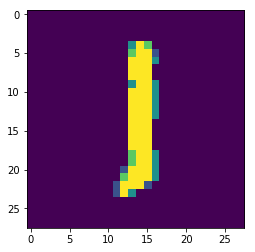

In [27]:
import time
import matplotlib.pyplot as plt

record = test_data_list[14]
all_values = record.strip('\n').split(',')
inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
plt.imshow(inputs.reshape(28, 28))
time.sleep(1)

In [17]:
import pickle
with open('network.pickle', 'rb') as file:
    network = pickle.load(file)

In [18]:
def ivan__denis(network):
    den_network = neuralNetwork(input_nodes,hidden_nodes,output_nodes, learning_rate)
    den_network.inodes = network.inodes
    den_network.hnodes = network.hnodes
    den_network.onodes = network.onodes

    den_network.lr = network.lr
    den_network.activation_function = network.activation_function
    
    den_network.who = network.who
    den_network.wih = network.wih
    return den_network

In [19]:
network = ivan__denis(network)

with open('network.pickle', 'wb') as f:
    pickle.dump(network, f)

In [21]:
n = network

(28, 28)
5


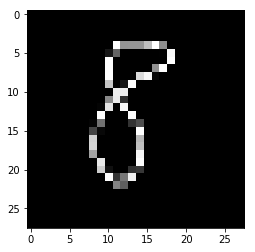

In [98]:
import imageio
import os

path = 'images/11_resized.png'
img_array = imageio.imread(path, as_gray=True)
print(img_array.shape)


plt.imshow(img_array.reshape(28,28), cmap='Greys', interpolation='None')

name_png = path.split('/')[-1]
name = os.path.join('images', name_png.split('.')[0] + '_resized' + '.' + name_png.split('.')[1])

data = resize_image(input_image_path=path,
                    output_image_path=name,
                    size=(28, 28))


data = numpy.asarray(data)

data = data.ravel()[::3]

img_array  = 255.0 - data.reshape(784)
    
img_array = (img_array / 255.0 * 0.99) + 0.01

outputs = network.query(img_array)

label = numpy.argmax(outputs)
print(label)

[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.99 0.01 0.01]


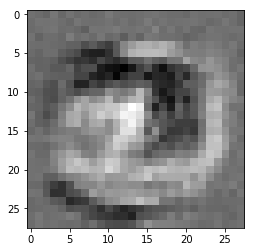

In [39]:
label = 7
targets = numpy.zeros(output_nodes) + 0.01
targets[label] = 0.99
print(targets)

image_data = n.backquery(targets)

plt.imshow(image_data.reshape(28,28), cmap='Greys', interpolation='None')

In [101]:
img_array.shape

(784,)